<a href="https://colab.research.google.com/github/Imane47250/TFHE_application_in_ML_inference/blob/master/MNIST_cite2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import psutil
import os
import tracemalloc
import random

from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from concrete.ml.torch.compile import compile_torch_model

# Reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Flatten and convert to numpy
X_train = train_dataset.data.numpy().reshape(-1, 28 * 28).astype("float32") / 255.0
y_train = train_dataset.targets.numpy().astype("int64")
X_test = test_dataset.data.numpy().reshape(-1, 28 * 28).astype("float32") / 255.0
y_test = test_dataset.targets.numpy().astype("int64")

print("Dataset loaded:", X_train.shape[0], "train,", X_test.shape[0], "test")

Dataset loaded: 60000 train, 10000 test


In [3]:
# Building a customizable MLP

activation_functions = {
    "relu": nn.ReLU(),
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
}

def build_mlp(input_dim=784, hidden_dim=128, n_hidden_layers=1, output_dim=10, activation="relu"):
    if activation not in activation_functions:
        raise ValueError("Unsupported activation: " + activation)

    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(activation_functions[activation])

    for _ in range(n_hidden_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(activation_functions[activation])

    layers.append(nn.Linear(hidden_dim, output_dim))

    return nn.Sequential(*layers)

In [4]:
model = build_mlp(hidden_dim=64, n_hidden_layers=2, activation="sigmoid")

In [5]:
# Training function

def train_model(model, X_train, y_train, epochs=5, batch_size=64, learning_rate=0.001):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.from_numpy(X_train) # convert nmpy array to pytorhc tensors objects :2D tensor of shape [60000, 784]
    y_train_tensor = torch.from_numpy(y_train) #1D tensor of shape [60000]
    num_batches = X_train_tensor.size(0) // batch_size # how many iterations happen inside each epoch

    for epoch in range(epochs):
      perm = torch.randperm(X_train_tensor.size(0))
      X_train_tensor = X_train_tensor[perm]
      y_train_tensor = y_train_tensor[perm]

      total_loss = 0.0
      for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        inputs = X_train_tensor[start:end]
        labels = y_train_tensor[start:end]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
      print("Epoch", epoch + 1, "Loss:", total_loss / num_batches)


    return model

In [6]:
trained_model = train_model(model, X_train, y_train, epochs=5)

Epoch 1 Loss: 0.8091235601660282
Epoch 2 Loss: 0.25896350909402177
Epoch 3 Loss: 0.18830607406469013
Epoch 4 Loss: 0.14908853625300217
Epoch 5 Loss: 0.12169584597927084


In [7]:
# Quantize and compile the model

from concrete.ml.torch.compile import compile_torch_model

def quantize_and_compile(model, X_calib, n_bits=6, rounding_threshold_bits=None):
    torch_input = torch.from_numpy(X_calib).float()

    if rounding_threshold_bits is None:
        rounding_threshold_bits = {"n_bits": n_bits, "method": "approximate"}

    quantized_module = compile_torch_model(
        model,
        torch_input,
        n_bits=n_bits,
        rounding_threshold_bits=rounding_threshold_bits
    )

    return quantized_module

In [8]:
# A somehow large calibration set for stable quantization
X_calib = X_train[:2000]
quantized_model = quantize_and_compile(trained_model, X_calib, n_bits=6)

In [9]:
def evaluate_model(model, quantized_module, X, y, fhe_mode="disable", batch_size=128):
    n = X.shape[0]

    # Clear path with batching
    model.eval()
    preds_clear_list = []
    for i in range(0, n, batch_size):
        xb = torch.from_numpy(X[i:i+batch_size])
        with torch.no_grad():
            outb = model(xb)
        preds_clear_list.append(torch.argmax(outb, dim=1).numpy())
    preds_clear = np.concatenate(preds_clear_list, axis=0)

    # Quantized path with batching
    tracemalloc.start()
    proc = psutil.Process(os.getpid())
    rss_before = proc.memory_info().rss
    t0 = time.time()

    preds_q_list = []
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size]
        outb = quantized_module.forward(xb, fhe=fhe_mode)
        preds_q_list.append(outb.argmax(axis=1))
    preds_q = np.concatenate(preds_q_list, axis=0)

    t1 = time.time()
    current_bytes, peak_bytes = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    rss_after = proc.memory_info().rss

    # Metrics
    acc_clear = accuracy_score(y, preds_clear)
    acc_q = accuracy_score(y, preds_q)

    # Agreement
    diff_q_clear = int(np.sum(preds_q != preds_clear))

    return {
        "clear_accuracy": float(acc_clear),
        "quantized_accuracy": float(acc_q),
        "inference_time_s": float(t1 - t0),
        "time_per_sample_s": float((t1 - t0) / n),
        "py_peak_mb": float(peak_bytes / 1e6),
        "rss_before_mb": float(rss_before / 1e6),
        "rss_after_mb": float(rss_after / 1e6),
        "diff_q_clear": diff_q_clear,
        "preds_clear": preds_clear,
        "preds_quant": preds_q,
    }


In [10]:
# Evaluation on a representative slice
X_eval = X_test[:2000].astype("float32")
y_eval = y_test[:2000]

# Simulate
res_sim = evaluate_model(trained_model, quantized_model, X_eval, y_eval, fhe_mode="simulate", batch_size=128)

print("Simulate results")
print("clear_accuracy", res_sim["clear_accuracy"])
print("quantized_accuracy", res_sim["quantized_accuracy"])
print("inference_time_s", res_sim["inference_time_s"])
print("time_per_sample_s", res_sim["time_per_sample_s"])
print("py_peak_mb", res_sim["py_peak_mb"])
print("rss_before_mb", res_sim["rss_before_mb"])
print("rss_after_mb", res_sim["rss_after_mb"])
print("diff_q_clear", res_sim["diff_q_clear"])

# Confusion matrix on clear baseline
cm = confusion_matrix(y_eval, res_sim["preds_clear"])
print("Confusion matrix shape", cm.shape)


Simulate results
clear_accuracy 0.9495
quantized_accuracy 0.948
inference_time_s 40.1132447719574
time_per_sample_s 0.0200566223859787
py_peak_mb 1.484611
rss_before_mb 1225.240576
rss_after_mb 1229.770752
diff_q_clear 36
Confusion matrix shape (10, 10)


In [11]:
from itertools import product

# Parameters grid
hidden_dims = [32, 64]
n_layers_list = [1, 2]
activations = ["relu", "sigmoid"]
n_bits_list = [4, 6]

# Collect results
rows = []

# Representative eval slice
X_eval = X_test[:2000].astype("float32")
y_eval = y_test[:2000]

for hidden_dim, n_layers, activation, n_bits in product(hidden_dims, n_layers_list, activations, n_bits_list):
    print("Running config", hidden_dim, "neurons", n_layers, "layers", activation, "activation", n_bits, "bits")

    # Build and train
    mdl = build_mlp(hidden_dim=hidden_dim, n_hidden_layers=n_layers, activation=activation)
    mdl = train_model(mdl, X_train, y_train, epochs=5)

    # Quantize and compile with large calibration
    qmdl = quantize_and_compile(mdl, X_train[:2000], n_bits=n_bits)

    # Simulate only for the grid
    met = evaluate_model(mdl, qmdl, X_eval, y_eval, fhe_mode="simulate", batch_size=128)

    rows.append({
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "activation": activation,
        "n_bits": n_bits,
        "acc_clear": met["clear_accuracy"],
        "acc_sim": met["quantized_accuracy"],
        "sim_time_s": met["inference_time_s"],
        "sim_time_per_sample_s": met["time_per_sample_s"],
        "py_peak_mb": met["py_peak_mb"],
        "rss_before_mb": met["rss_before_mb"],
        "rss_after_mb": met["rss_after_mb"],
        "diff_sim_clear": met["diff_q_clear"],
    })

df_results = pd.DataFrame(rows)
print(df_results.head())

# Save to CSV
df_results.to_csv("mnist_quant_grid.csv", index=False)

Running config 32 neurons 1 layers relu activation 4 bits
Epoch 1 Loss: 0.45252669102481485
Epoch 2 Loss: 0.22661451703154162
Epoch 3 Loss: 0.1794396727698733
Epoch 4 Loss: 0.1508125798973546
Epoch 5 Loss: 0.1320067195891698
Running config 32 neurons 1 layers relu activation 6 bits
Epoch 1 Loss: 0.46273704848014685
Epoch 2 Loss: 0.22910748681365617
Epoch 3 Loss: 0.1813320962388144
Epoch 4 Loss: 0.15230069827515008
Epoch 5 Loss: 0.13360655053718495
Running config 32 neurons 1 layers sigmoid activation 4 bits
Epoch 1 Loss: 0.7970989367178181
Epoch 2 Loss: 0.31256127013976953
Epoch 3 Loss: 0.24804890413421704
Epoch 4 Loss: 0.21384053370789122
Epoch 5 Loss: 0.19120359574240833
Running config 32 neurons 1 layers sigmoid activation 6 bits
Epoch 1 Loss: 0.8103324300992196
Epoch 2 Loss: 0.31695806449766223
Epoch 3 Loss: 0.24956119085961243
Epoch 4 Loss: 0.2158260002946968
Epoch 5 Loss: 0.1933359925534771
Running config 32 neurons 2 layers relu activation 4 bits
Epoch 1 Loss: 0.4637442763294456

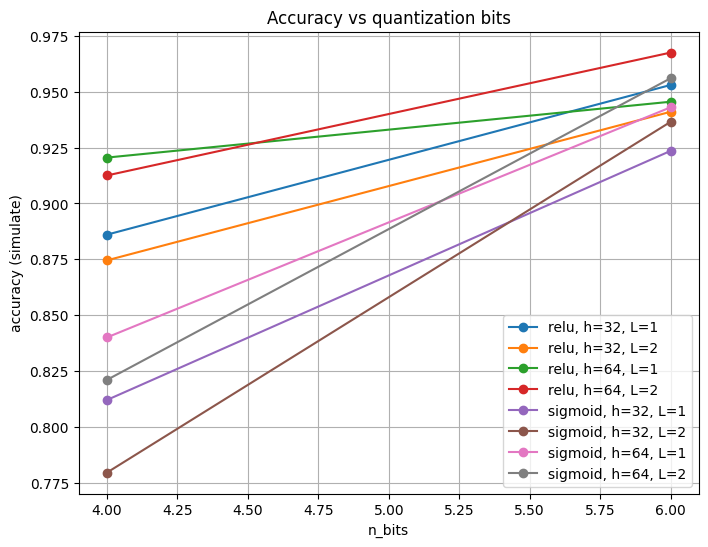

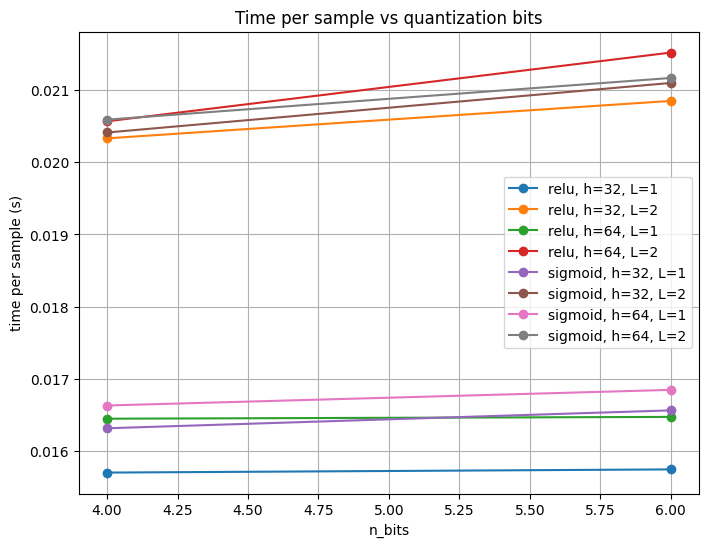

In [12]:
import matplotlib.pyplot as plt

# Basic checks
if "df_results" not in globals():
    raise RuntimeError("df_results is not defined. Run the grid cell first.")

required_cols = [
    "activation", "n_bits", "acc_sim",
    "sim_time_per_sample_s", "hidden_dim", "n_layers"
]
missing = [c for c in required_cols if c not in df_results.columns]
if missing:
    raise RuntimeError("df_results is missing columns " + str(missing))

# Ensure proper dtypes
df_plot = df_results.copy()
df_plot["n_bits"] = df_plot["n_bits"].astype(int)
df_plot = df_plot.sort_values(["activation", "hidden_dim", "n_layers", "n_bits"])

# Plot 1. Accuracy vs n_bits
plt.figure(figsize=(8, 6))
groups = df_plot.groupby(["activation", "hidden_dim", "n_layers"])
for (act, h, L), g in groups:
    plt.plot(g["n_bits"].values, g["acc_sim"].values, marker="o",
             label=act + ", h=" + str(h) + ", L=" + str(L))
plt.title("Accuracy vs quantization bits")
plt.xlabel("n_bits")
plt.ylabel("accuracy (simulate)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2. Time per sample vs n_bits
plt.figure(figsize=(8, 6))
for (act, h, L), g in groups:
    plt.plot(g["n_bits"].values, g["sim_time_per_sample_s"].values, marker="o",
             label=act + ", h=" + str(h) + ", L=" + str(L))
plt.title("Time per sample vs quantization bits")
plt.xlabel("n_bits")
plt.ylabel("time per sample (s)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Real FHE execute on a modest subset to control runtime
X_exec = X_test[:256].astype("float32")
y_exec = y_test[:256]

res_exec = evaluate_model(trained_model, quantized_model, X_exec, y_exec, fhe_mode="execute", batch_size=64)

print("Execute results")
print("clear_accuracy", res_exec["clear_accuracy"])
print("quantized_accuracy", res_exec["quantized_accuracy"])
print("inference_time_s", res_exec["inference_time_s"])
print("time_per_sample_s", res_exec["time_per_sample_s"])
print("py_peak_mb", res_exec["py_peak_mb"])
print("rss_before_mb", res_exec["rss_before_mb"])
print("rss_after_mb", res_exec["rss_after_mb"])
print("diff_q_clear", res_exec["diff_q_clear"])

Execute results
clear_accuracy 0.9765625
quantized_accuracy 0.9765625
inference_time_s 954.497255563736
time_per_sample_s 3.7285049045458436
py_peak_mb 0.617218
rss_before_mb 1293.115392
rss_after_mb 4721.025024
diff_q_clear 5


In [14]:
# Compare simulate and execute on the same slice for perfect apples to apples
X_eval_agree = X_test[:256].astype("float32")
y_eval_agree = y_test[:256]

res_sim_small = evaluate_model(trained_model, quantized_model, X_eval_agree, y_eval_agree, fhe_mode="simulate", batch_size=64)
res_exec_small = evaluate_model(trained_model, quantized_model, X_eval_agree, y_eval_agree, fhe_mode="execute", batch_size=64)

preds_clear = res_sim_small["preds_clear"]
preds_sim   = res_sim_small["preds_quant"]
preds_exec  = res_exec_small["preds_quant"]

diff_sim_clear  = int(np.sum(preds_sim  != preds_clear))
diff_exec_clear = int(np.sum(preds_exec != preds_clear))
diff_exec_sim   = int(np.sum(preds_exec != preds_sim))

print("Agreement on 256 samples")
print("diff sim vs clear", diff_sim_clear)
print("diff exec vs clear", diff_exec_clear)
print("diff exec vs sim", diff_exec_sim)

Agreement on 256 samples
diff sim vs clear 3
diff exec vs clear 2
diff exec vs sim 1


Confusion matrix shape (10, 10)


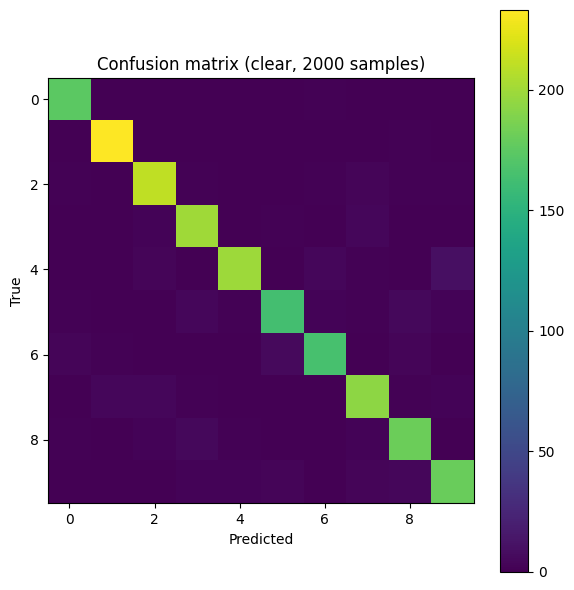

Number of misclassified in clear 101


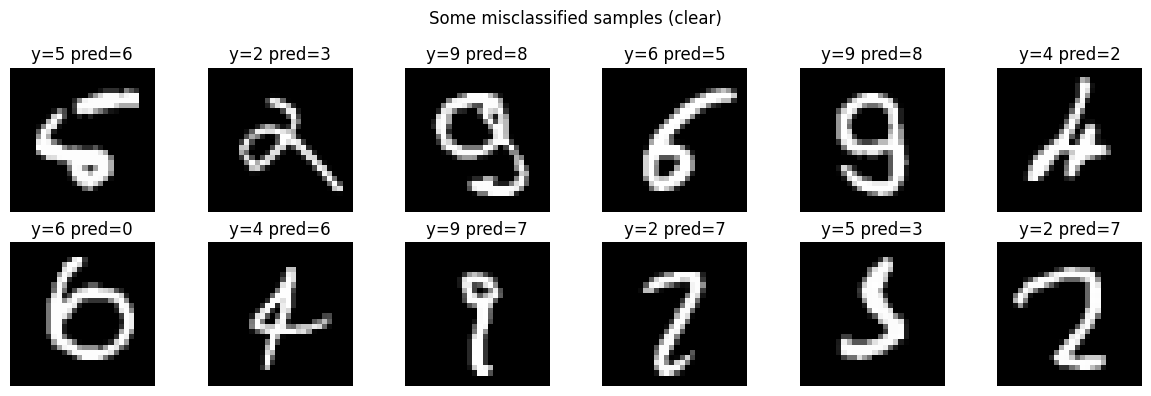

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Clear predictions on 2000-sample eval slice from cellule10
y_clear_eval = res_sim["preds_clear"]
cm = confusion_matrix(y_eval, y_clear_eval)
print("Confusion matrix shape", cm.shape)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix (clear, 2000 samples)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# Show a few misclassified images
mis_idx = np.where(y_clear_eval != y_eval)[0]
print("Number of misclassified in clear", len(mis_idx))

show_k = 12
k = min(show_k, len(mis_idx))
if k > 0:
    plt.figure(figsize=(12, 4))
    for i in range(k):
        idx = mis_idx[i]
        img = X_eval[idx].reshape(28, 28)
        plt.subplot(2, (show_k + 1) // 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title("y=" + str(y_eval[idx]) + " pred=" + str(y_clear_eval[idx]))
        plt.axis("off")
    plt.suptitle("Some misclassified samples (clear)")
    plt.tight_layout()
    plt.show()

In [16]:
# Consolidate one summary row for report usage
summary_row = {
    "mode": "simulate_2000",
    "acc_clear": res_sim["clear_accuracy"],
    "acc_quant": res_sim["quantized_accuracy"],
    "time_total_s": res_sim["inference_time_s"],
    "time_per_sample_s": res_sim["time_per_sample_s"],
    "py_peak_mb": res_sim["py_peak_mb"],
    "rss_before_mb": res_sim["rss_before_mb"],
    "rss_after_mb": res_sim["rss_after_mb"],
    "diff_q_clear": res_sim["diff_q_clear"],
}

summary_row_exec = {
    "mode": "execute_256",
    "acc_clear": res_exec["clear_accuracy"],
    "acc_quant": res_exec["quantized_accuracy"],
    "time_total_s": res_exec["inference_time_s"],
    "time_per_sample_s": res_exec["time_per_sample_s"],
    "py_peak_mb": res_exec["py_peak_mb"],
    "rss_before_mb": res_exec["rss_before_mb"],
    "rss_after_mb": res_exec["rss_after_mb"],
    "diff_q_clear": res_exec["diff_q_clear"],
}

df_summary = pd.DataFrame([summary_row, summary_row_exec])
print(df_summary)

# Save both grid and summary
df_results.to_csv("mnist_quant_grid.csv", index=False)
df_summary.to_csv("mnist_fhe_summary.csv", index=False)

            mode  acc_clear  acc_quant  time_total_s  time_per_sample_s  \
0  simulate_2000   0.949500   0.948000     40.113245           0.020057   
1    execute_256   0.976562   0.976562    954.497256           3.728505   

   py_peak_mb  rss_before_mb  rss_after_mb  diff_q_clear  
0    1.484611    1225.240576   1229.770752            36  
1    0.617218    1293.115392   4721.025024             5  
